

# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
# import packages
%matplotlib inline
import math
import time
from datetime import timedelta
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tqdm import tqdm

# set matplotlib defaults
#plt.rcParams['figure.figsize'] = (25.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

In [2]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "dataset/train.p"
testing_file = "dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0,:,:,:].shape

# TODO: how many classes are in the dataset
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [2]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# this method modified from reference #3
def plot_random_images(X_data, y_data, samples_per_class=3):
    div_classes = n_classes//3
    class_subsets = [np.arange(0,div_classes), 
                     np.arange(div_classes,2*div_classes),
                     np.arange(2*div_classes,3*div_classes+1)] # 43 classes
    for classes in class_subsets:
        for y in classes:
            idxs = np.flatnonzero(y_data == y)
            idxs = np.random.choice(idxs, samples_per_class, replace=False)
            for i, idx in enumerate(idxs):
                plt_idx = i * n_classes + y + 1
                plt.subplot(samples_per_class, n_classes, plt_idx)
                plt.imshow(X_data[idx].astype('uint8'))
                plt.axis('off')
                if i == 0:
                    plt.title(y)
        plt.show()

# this method borrowed from reference #2
def plot_images(images, cls_true, cls_pred=None, image_shape=(32,32,3)):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(image_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()        

def plot_tracks(images, n_tracks, track_size=30, image_shape=(32,32,3)):
    sample_idxs = np.arange(1,n_tracks*track_size)
    fig, axes = plt.subplots(n_tracks, track_size, figsize=(10,3))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(image_shape), cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])  
    plt.show()

A random sample of images


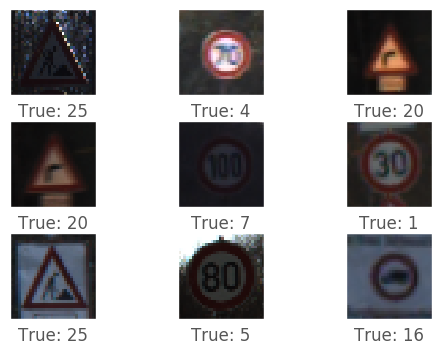

A sample of a several 'tracks' of images


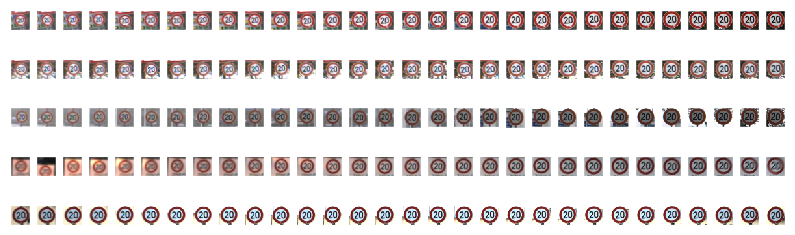

In [5]:
print("A random sample of images")
sample_idxs = np.random.choice(n_train, 9, replace=False)
plot_images(X_train[sample_idxs], y_train[sample_idxs])  

print("A sample of a several 'tracks' of images")
plot_tracks(X_train, 5)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
def convert_images(images):
    """ Method to convert images to grayscale """
    out = []
    for n in tqdm(range(images.shape[0])):
        img = images[n,:,:,:]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.equalizeHist(img)
        img = img/255.0
        out.append(img)
    return out  

def jitter(img):
    """ Method to generate a single output image by applying random jitter to the input"""
    width, height = img.shape
    x_scaled = int(np.random.uniform(.98,1.2) * width)
    y_scaled = int(np.random.uniform(.98,1.2) * height)
    img = cv2.resize(img, (x_scaled, y_scaled), interpolation = cv2.INTER_CUBIC)
    
    x_shift = int(np.random.uniform(-2,2))
    y_shift = int(np.random.uniform(-2,2))
    M = np.float32([[1,0,x_shift],[0,1,y_shift]])
    img = np.lib.pad(img, (5, 5), 'reflect')
    rows, cols = img.shape
    dst = cv2.warpAffine(img,M,(cols,rows))
    #if dst.shape != (32,32):
    #    np.lib.pad(a, (2, 3), 'reflect')
    x0 = int((cols/2)-(width/2))
    y0 = int((rows/2)-(height/2))
    return dst[x0:width+x0,y0:height+y0]

def produce_jitter(X, y, n_jitter=5):
    """ Method to generate additional images by applying random jitter to the inputs """
    outX, outY = [], []
    for n in tqdm(range(X.shape[0])):
        img = X[n,:,:]
        for i in range(n_jitter):
            outX.append(jitter(img))
            outY.append(y[n])
    return outX, outY

In [7]:
# convert all train and test features to normalized grayscale
X_train_data = np.array(convert_images(X_train))
X_test_data = np.array(convert_images(X_test))

# extract one sample track from each class for validation set
samples_per_class = 1
extract_idxs = []
for y in np.unique(y_train):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    idxs = idxs - idxs % 30 # get start of track
    extract_idxs.extend(idxs + np.arange(30))
    
X_val_data = X_train_data[extract_idxs]
y_val_data = y_train[extract_idxs]
X_train_data = np.delete(X_train_data, extract_idxs, axis=0)
y_train_data = np.delete(y_train, extract_idxs, axis=0)

# reinitialize training length
n_train = X_train_data.shape[0]

n_jitter = 3
X_gen_data, y_gen_data = produce_jitter(X_train_data, y_train_data, n_jitter)
X_gen_data = np.array(X_gen_data)
y_gen_data = np.array(y_gen_data)

100%|██████████| 37919/37919 [00:15<00:00, 2413.31it/s]


Sample of images generated with random jitter


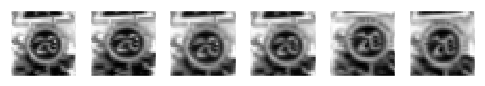

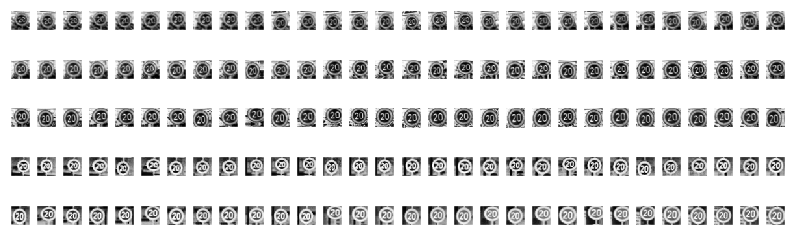

In [8]:
def plot_single_image(img, ax):
    ax.imshow(img, cmap="binary")
    ax.set_xticks([])
    ax.set_yticks([])  
    
fig, ax = plt.subplots(1,6)
plot_single_image(X_train_data[0], ax[0])

print("Sample of images generated with random jitter")
for i in range(0,5):
    plot_single_image(X_gen_data[i], ax[1+i])
    
plot_tracks(X_gen_data, 5, image_shape=(32,32)) 

Sample of images from training dataset after equalization and normalization


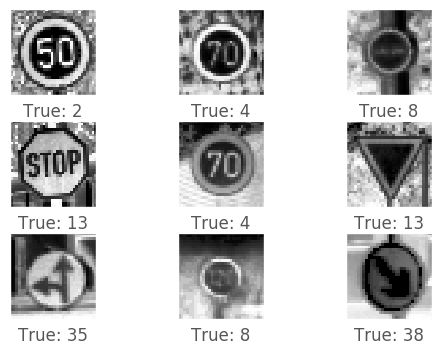

Sample of several tracks of training images


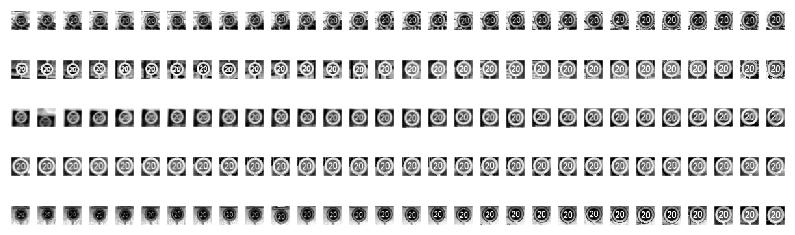

Sample of several tracks from validation set


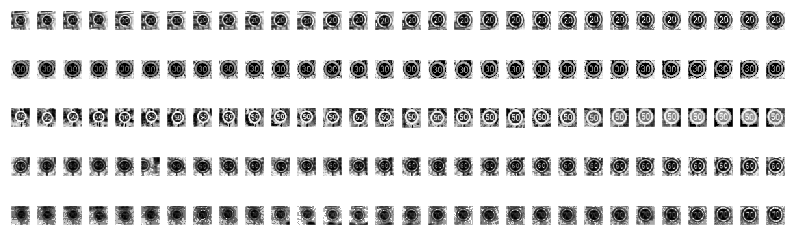

In [9]:
print("Sample of images from training dataset after equalization and normalization")
sample_idxs = np.random.choice(n_train, 9, replace=False)
plot_images(X_train_data[sample_idxs], y_train[sample_idxs], image_shape=(32,32))

print("Sample of several tracks of training images")
plot_tracks(X_train_data, 5, image_shape=(32,32))

print("Sample of several tracks from validation set")
plot_tracks(X_val_data,5,image_shape=(32,32))

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** 

To preprocess the data I first used cv2 to convert each image to grayscale and apply a histogram equalization to the image in order to improve the contrast for images which have very low contrast.

In [10]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
print(X_train_data.shape, X_gen_data.shape, y_train_data.shape, y_gen_data.shape)
# join normalized training data with additional fake data
# and copy other features and labels for consistency
X_train_features = np.concatenate((X_train_data, X_gen_data), axis=0)
y_train_labels = np.concatenate((y_train_data, y_gen_data), axis=0)

del X_train, X_train_data, y_train, y_train_data

X_val_features = X_val_data
y_val_labels = y_val_data
X_test_features = X_test_data
y_test_labels = y_test

# reinitialize length variables
n_train = X_train_features.shape[0]
n_val = X_val_features.shape[0]

# generate random set of indexes to randomize inputs for test data
new_idxs = np.random.choice(n_train, n_train, replace=False) 
X_train_features = X_train_features[new_idxs]
y_train_labels = y_train_labels[new_idxs]

# generate random set of indexes to randomize inputs for validation data
new_idxs = np.random.choice(n_val, n_val, replace=False) 
X_val_features = X_val_features[new_idxs]
y_val_labels = y_val_labels[new_idxs]

print("New datasets:\nn_train={}, n_val={}, n_test={}".format(n_train, n_val, n_test))

(37919, 32, 32) (113757, 32, 32) (37919,) (113757,)
New datasets:
n_train=151676, n_val=1290, n_test=12630


In [13]:
# store the data for re-use
new_data = {
    "X_train_features": X_train_features,
    "y_train_labels": y_train_labels,
    "X_val_features": X_val_features,
    "y_val_labels": y_val_labels,
    "X_test_features": X_test_data,
    "y_test_labels": y_test_labels
}
with open("new_data.pickle", "wb") as f:
    pickle.dump(new_data, f)

In [3]:
import pickle

# load the data if it does not exist in the environment
try:
    X_train_features;
    y_train_labels;
    X_val_features;
    y_val_labels;
    X_test_data;
    y_test_labels;
except:
    with open("new_data.pickle", "rb") as f:
        new_data = pickle.load(f)
        X_train_features = new_data['X_train_features']
        y_train_labels = new_data['y_train_labels']
        X_val_features = new_data['X_val_features']
        y_val_labels = new_data['y_val_labels']
        X_test_features = new_data['X_test_features']
        y_test_labels = new_data['y_test_labels']
        
        n_train = X_train_features.shape[0]
        n_val = X_val_features.shape[0]
        n_test = X_test_features.shape[0]
        del new_data

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** 
To create the validation set I first extract one random "track" of 30 images for each class from the training data, and store this as the validation set. The whole track is removed from the training set entirely in order to prevent "bleed over" or fitting to that data when training, which would contribute to artificially high accuracy when evaluating against the validation set.

I also generate additional input data by iterating over the input features to generate new features which are transformed and scaled by a random small amount. This is to add more data and hopefully allow the model to better predict inputs which have slight deviances in position and scale.

Finally, I randomize the new input/validation features and corresponding labels to generate the final set of features which will be fed into the model. Randomizing the inputs prevents the model from converging too quickly to the first classes its sees when performining minibatch.

In [59]:
try:
    session.close()
    tf.reset_default_graph()
except:
    pass
    
#Hyperparameters
hp = {
    "learning_rate": 1e-3,
    "batch_size": 64,
    "dropout": 0.75,
    "wc1_shape": [5, 5, 1, 16],
    "wc2_shape": [5, 5, 16, 36],
    "wd1_shape": [8*8*36, 128]
}

n_classes = 43 # repeated for clarity
display_step = 100

def initialize_variable(scope_name, var_name, shape):
    with tf.variable_scope(scope_name) as scope:
        v = tf.get_variable(var_name, shape)
        scope.reuse_variable()

def get_scope_variable(scope_name, var_name):
    with tf.variable_scope(scope_name, reuse=True):
        v = tf.get_variable(var_name)
    return v  

In [60]:
# Store layers weight & bias
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

weights = {
    'wc1': new_weights(hp["wc1_shape"]),
    'wc2': new_weights(hp["wc2_shape"]),
    'wd1': new_weights(hp["wd1_shape"]),
    'out': new_weights([hp["wd1_shape"][-1], n_classes])
}

biases = {
    'bc1': new_biases(hp["wc1_shape"][-1]),
    'bc2': new_biases(hp["wc2_shape"][-1]),
    'bd1': new_biases(hp["wd1_shape"][-1]),
    'out': new_biases(n_classes)
}

In [61]:
# from https://www.tensorflow.org/versions/r0.11/how_tos/summaries_and_tensorboard/index.html
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.scalar_summary('stddev/' + name, stddev)
            tf.scalar_summary('max/' + name, tf.reduce_max(var))
            tf.scalar_summary('min/' + name, tf.reduce_min(var))
            tf.histogram_summary(name, var)

In [62]:
# Create some wrappers for simplicity
def conv2d(x, W, b, layer_name, strides=1):
    # Conv2D wrapper, with bias and relu activation
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            variable_summaries(W, layer_name + '/weights')
        with tf.name_scope('biases'):
            variable_summaries(b, layer_name + '/biases')
        with tf.name_scope('conv2d'):
            x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
            tf.histogram_summary(layer_name + '/conv2d', x)
        with tf.name_scope('conv2d_plus_bias'):
            x = tf.nn.bias_add(x, b)
            tf.histogram_summary(layer_name + '/activations', x)
        return tf.nn.relu(x)

def maxpool2d(x, layer_name, k=2):
    # MaxPool2D wrapper
    x = tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')
    tf.histogram_summary(layer_name + '/maxpool2d', x)
    return x

def batch_norm(x, train_phase, scope, layer_name):
    bn_train = tf.contrib.layers.python.layers.batch_norm(x, 
                    decay=0.999, center=True, scale=True,
                    updates_collections=None,
                    is_training=True,
                    reuse=None, # is this right?
                    trainable=True)
    bn_inference = tf.contrib.layers.python.layers.batch_norm(x, 
                    decay=0.999, center=True, scale=True,
                    updates_collections=None,
                    is_training=False,
                    reuse=False, # is this right?
                    trainable=True)
    x = tf.cond(train_phase, lambda: bn_train, lambda: bn_inference)
    tf.histogram_summary(layer_name + '/batchnorm', x)
    return x

In [63]:
def get_batch(x, y, stop=False, n=64):
    i = 0
    while not stop:
        i += 1
        if i > x.shape[0] // n:
            i = 0
        yield x[n*i:n*(i+1)], y[n*i:n*(i+1)]

batches = get_batch(X_train_features, y_train_labels, n=hp['batch_size'])

In [64]:
# Construct model
session = tf.Session()  

#saver.restore(session, "/tmp/model_20161119_1811.ckpt")

# tf Graph input
#with tf.name_scope('input'):
x_inp = tf.placeholder(tf.float32, [None, 32, 32], name='x_inp')
y_inp = tf.placeholder(tf.int64, [None], name='y_inp')

# x reshape and one hot encode y
with tf.name_scope('input_reshape'):
    x = tf.reshape(x_inp, shape=[-1, 32, 32, 1])
    y = tf.one_hot(y_inp, n_classes)

# Convolution Layer
conv1 = conv2d(x, weights['wc1'], biases['bc1'], 'conv1') 

# Max Pooling (down-sampling)
conv1 = maxpool2d(conv1, layer_name='maxpool1', k=2)

# Convolution Layer
conv2 = conv2d(conv1, weights['wc2'], biases['bc2'], 'conv2')

# Max Pooling (down-sampling)
conv2 = maxpool2d(conv2, 'maxpool2', k=2)

# Fully connected layer
# Reshape conv2 output to fit fully connected layer input
with tf.name_scope('fully_connected1'):
    with tf.name_scope('weights'):
        variable_summaries(weights['wd1'], 'fully_connected1/weights')
    with tf.name_scope('biases'):
        variable_summaries(biases['bd1'], 'fully_connected1/biases')

    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.matmul(fc1, weights['wd1']) + biases['bd1']
    tf.histogram_summary('fully_connected1/WX_plus_B', fc1)

# Batch normalization per recommendation from https://arxiv.org/pdf/1502.03167v3.pdf
with tf.name_scope('batchnorm1'):
    train_phase = tf.placeholder(tf.bool, name='train_phase')
    fc1 = batch_norm(fc1, train_phase, 'batchnorm1', 'batchnorm1')

# ReLU
with tf.name_scope('fc_relu'):
    fc1 = tf.nn.relu(fc1)

# Apply Dropout
with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
    tf.scalar_summary('dropout_keep_probability', keep_prob)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
# Output, class prediction
with tf.name_scope('pred'):
    pred = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    #tf.scalar_summary('pred', pred)
    
# Define loss and optimizer
with tf.name_scope('softmax_cross_entropy'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
    tf.scalar_summary('softmax_cross_entropy', cost)
    
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=hp['learning_rate']).minimize(cost)

# Evaluate model
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    tf.scalar_summary('accuracy', accuracy)

session.run(tf.initialize_all_variables())
saver = tf.train.Saver()

# store summaries for tensorboard
merged = tf.merge_all_summaries()
summaries_dir = '/tmp/tf/'
train_writer = tf.train.SummaryWriter(summaries_dir + 'train', session.graph)
test_writer = tf.train.SummaryWriter(summaries_dir + 'test')

total_iterations = 0
loss_hist = []
acc_hist = []
iter_hist = []

def optimize(num_iterations):
    global total_iterations, loss_hist, acc_hist, iter_hist
        
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    for i in range(total_iterations, total_iterations + num_iterations):
        # run optimization op (backprop)
        batch_x, batch_y = next(batches)
        summary, _ = session.run([merged, optimizer], feed_dict={x_inp: batch_x, 
                                                                 y_inp: batch_y, 
                                                                 keep_prob: hp['dropout'], 
                                                                 train_phase: True})
        train_writer.add_summary(summary, i)
        if i % display_step == 0:
            # Calculate batch loss and accuracy
            summary, loss, acc = session.run([merged, cost, accuracy], 
                                             feed_dict={x_inp: batch_x, 
                                                        y_inp: batch_y, 
                                                        keep_prob: 1.0, 
                                                        train_phase: False})
            test_writer.add_summary(summary, i)
            
            loss_hist.append(loss)
            acc_hist.append(acc)
            iter_hist.append(i)
            
            msg = "Iter: {0:>6}, Minibatch Loss: {1:>6.6f}, Training Accuracy: {2:>6.1%}"
            print(msg.format(i+1, loss, acc))
            
            
    total_iterations += num_iterations
    
    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # save checkpoint
    saver.save(session, "/tmp/tf/model_%s.ckpt" % dt.datetime.now().strftime("%Y%m%d_%H%M"))
    
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [65]:
def store_model(filename):
    loss, acc = session.run([cost, accuracy], feed_dict={x_inp: X_val_features,
                                                    y_inp: y_val_labels,
                                                    keep_prob: 1.,
                                                    train_phase: False})
    print("Accuracy on validation set: {0:>6.1%}".format(acc))
    out_model = {
        "hyperparameters": hp,
        "weights": session.run(weights),
        "biases": session.run(biases),
        "validation_accuracy": acc,
        "validation_loss": loss
    }
    with open(filename, 'wb') as handle:
          pickle.dump(out_model, handle)

In [66]:
optimize(25000)

Iter:      1, Minibatch Loss: 3.744661, Training Accuracy:   3.1%
Iter:    101, Minibatch Loss: 3.463299, Training Accuracy:  28.1%
Iter:    201, Minibatch Loss: 3.376827, Training Accuracy:  28.1%
Iter:    301, Minibatch Loss: 3.215048, Training Accuracy:  45.3%
Iter:    401, Minibatch Loss: 3.261029, Training Accuracy:  31.2%
Iter:    501, Minibatch Loss: 3.115039, Training Accuracy:  43.8%
Iter:    601, Minibatch Loss: 3.197467, Training Accuracy:  42.2%
Iter:    701, Minibatch Loss: 3.075643, Training Accuracy:  59.4%
Iter:    801, Minibatch Loss: 2.930576, Training Accuracy:  73.4%
Iter:    901, Minibatch Loss: 2.917650, Training Accuracy:  76.6%
Iter:   1001, Minibatch Loss: 2.922166, Training Accuracy:  67.2%
Iter:   1101, Minibatch Loss: 2.962020, Training Accuracy:  76.6%
Iter:   1201, Minibatch Loss: 2.837544, Training Accuracy:  73.4%
Iter:   1301, Minibatch Loss: 2.742764, Training Accuracy:  92.2%
Iter:   1401, Minibatch Loss: 2.874258, Training Accuracy:  67.2%
Iter:   15

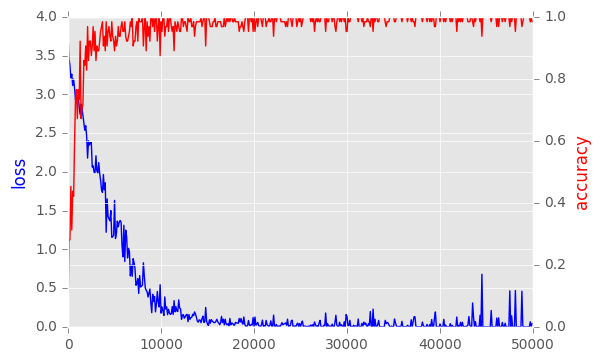

12630
Accuracy on test set:  93.0%


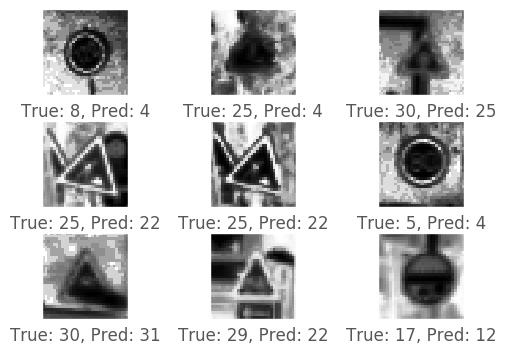

In [67]:
fig, ax1 = plt.subplots()
ax1.plot(iter_hist, loss_hist, 'b')
ax1.set_ylabel('loss', color='b')

ax2 = ax1.twinx()
ax2.plot(iter_hist, acc_hist, 'r')
ax2.set_ylabel('accuracy', color='r')

plt.show();

#test_idxs = np.random.choice(n_val, 256, replace=False)
test_idxs = np.arange(n_test)
print(n_test)
acc = session.run(accuracy, feed_dict={x_inp: X_test_features[test_idxs],
                                 y_inp: y_test_labels[test_idxs],
                                 keep_prob: 1.,
                                 train_phase: False})
print("Accuracy on test set: {0:>6.1%}".format(acc))

pred_res = session.run(pred, feed_dict={x_inp: X_test_features[test_idxs],
                                 y_inp: y_test_labels[test_idxs],
                                 keep_prob: 1.,
                                 train_phase: False})
true_classes = y_test_labels[test_idxs]
pred_classes = np.argmax(pred_res, axis=1)
failure_idxs = true_classes != pred_classes
failures = test_idxs[failure_idxs]

plot_images(X_test_features[failures[:9],:,:], 
            y_test_labels[failures[:9]], 
            cls_pred = pred_classes[failure_idxs],
            image_shape=(32,32))

In [1]:
fig, ax1 = plt.subplots()
ax1.plot(iter_hist, loss_hist, 'b')
ax1.set_ylabel('loss', color='b')

ax2 = ax1.twinx()
ax2.plot(iter_hist, acc_hist, 'r')
ax2.set_ylabel('accuracy', color='r')

plt.show();

val_idxs = np.arange(n_val)
acc = session.run(accuracy, feed_dict={x_inp: X_val_features,
                                 y_inp: y_val_labels,
                                 keep_prob: 1.,
                                 train_phase: False})
print("Accuracy on validation set: {0:>6.1%}".format(acc))

pred_res = session.run(pred, feed_dict={x_inp: X_val_features,
                                 y_inp: y_val_labels,
                                 keep_prob: 1.,
                                 train_phase: False})
true_classes = y_val_labels
pred_classes = np.argmax(pred_res, axis=1)
failure_idxs = true_classes != pred_classes
failures = val_idxs[failure_idxs]

plot_images(X_val_features[failures[:9],:,:], 
            y_val_labels[failures[:9]], 
            cls_pred = pred_classes[failure_idxs],
            image_shape=(32,32))

NameError: name 'plt' is not defined

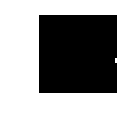

[38] 38


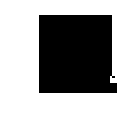

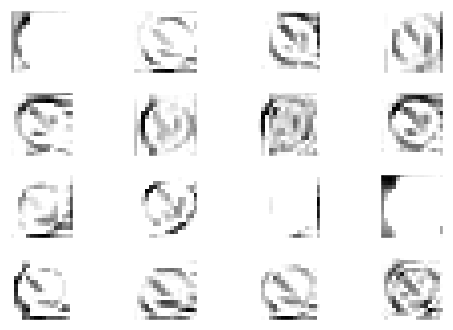

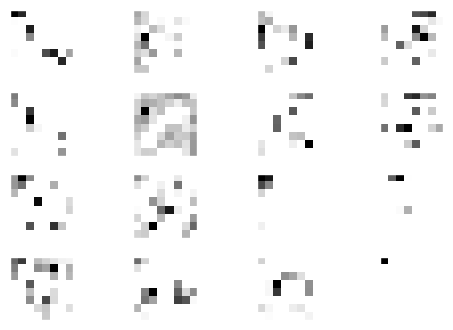

In [68]:
def plot_sample(x):
    plt.figure(figsize=(1,1))
    if x.max() < 1:
        x = 255*x
    plt.imshow(x.astype('uint8'))
    plt.axis('off')

def plot_layer(x):
    fig, axes = plt.subplots(4, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[0,:,:,i], cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])

s = 5
x_sample = X_test_features[s:s+1,:,:]
y_sample = y_test_labels[s:s+1]
fd= {x_inp: x_sample,
     y_inp: y_sample,
     keep_prob: 1.,
     train_phase: False}
pred_res = session.run(pred, feed_dict=fd)
cnv1 = session.run(conv1, feed_dict=fd)
cnv2 = session.run(conv2, feed_dict=fd)

plot_sample(x_sample[0]); plt.show()
plot_sample(X_train_features[y_train_labels==3][0])
print(y_sample, pred_res.argmax())
plot_layer(cnv1)
plot_layer(cnv2)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [69]:
### Train your model here.
### Feel free to use as many code cells as needed.
#session.close()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [70]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [71]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [72]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

# References
1. https://www.tensorflow.org/versions/r0.11/tutorials/deep_cnn/index.html
2. https://github.com/Hvass-Labs/TensorFlow-Tutorials
3. http://cs231n.github.io/
4. https://arxiv.org/pdf/1502.03167v3.pdf